In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import warnings

In [10]:
df = pd.read_csv('/content/drive/MyDrive/final assignment/water_potability.csv')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [12]:
shape= df.shape
print(shape)

(3276, 10)


In [13]:
df.isnull().sum()

,0
ph,491
Hardness,0
Solids,0
Chloramines,0
Sulfate,781
Conductivity,0
Organic_carbon,0
Trihalomethanes,162
Turbidity,0
Potability,0


In [14]:
df.fillna(df.median(), inplace=True)

#verifiying no missing value remaining
df.isnull().sum()

,0
ph,0
Hardness,0
Solids,0
Chloramines,0
Sulfate,0
Conductivity,0
Organic_carbon,0
Trihalomethanes,0
Turbidity,0
Potability,0


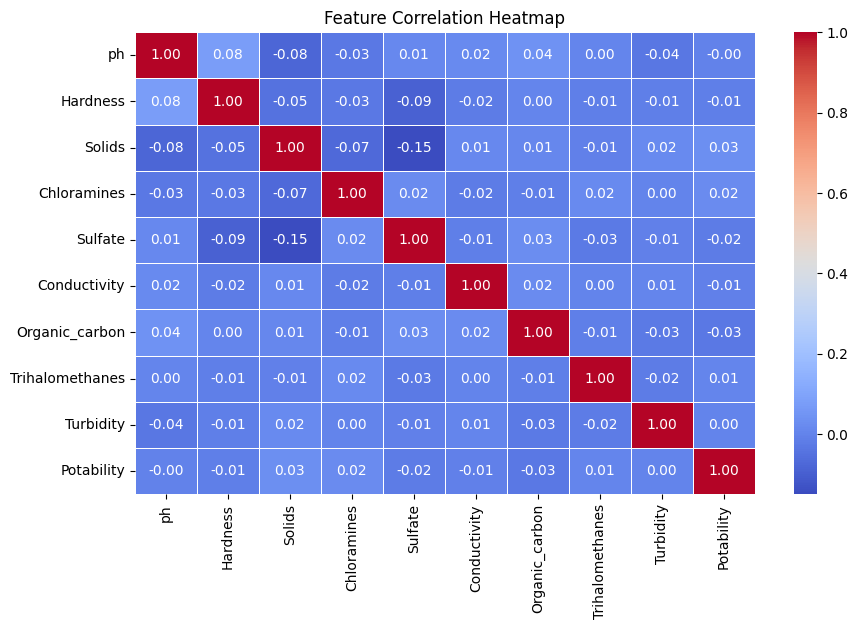

In [15]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

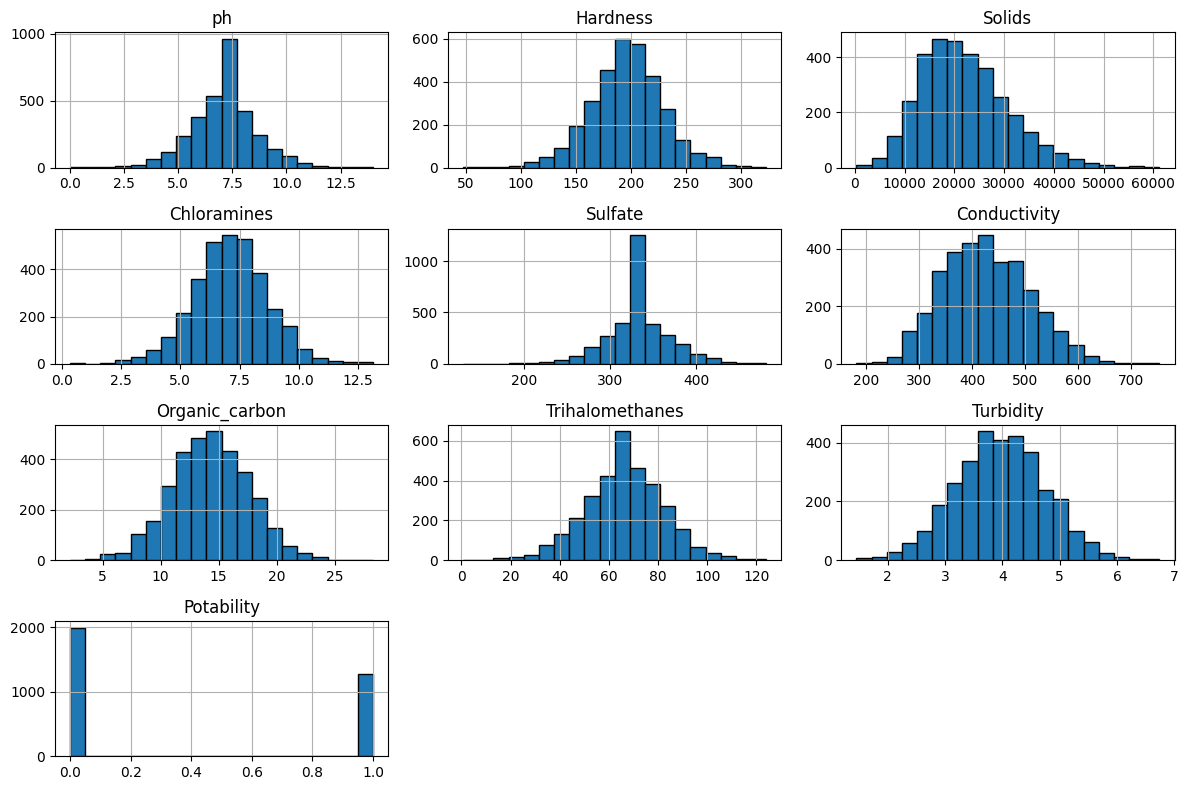

In [17]:
df.hist(figsize=(12, 8), bins = 20, edgecolor = 'black')
plt.tight_layout()
plt.show()

**MODEL FROM SCRATCH**

Training MSE: 2.1068, Training R²: 0.0146
Testing MSE: 2.2043, Testing R²: 0.0196


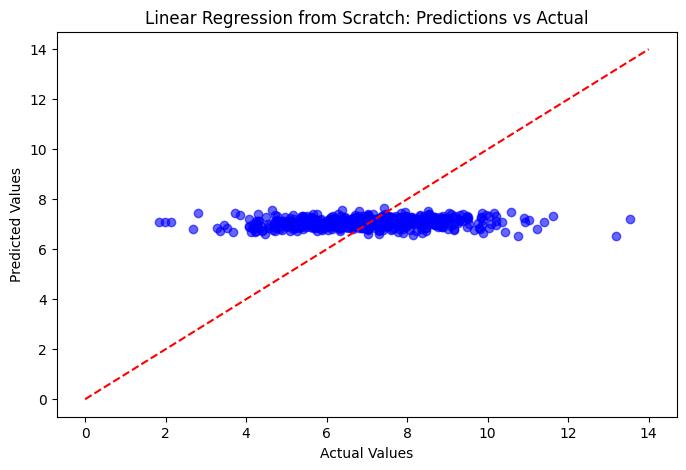

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define features (X) and target variable (y)
X = df.drop(columns=['ph']).values  # Convert to numpy array
y = df['ph'].values

# Manually split dataset into training and testing sets (80-20 split)
def train_test_split_manual(X, y, test_size=0.2, seed=42):
    np.random.seed(seed)
    indices = np.arange(len(y))
    np.random.shuffle(indices)

    test_size = int(len(y) * test_size)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = train_test_split_manual(X, y)

# Manually standardize features
def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std, mean, std

X_train_scaled, mean, std = standardize(X_train)
X_test_scaled = (X_test - mean) / std

# Add bias term (intercept)
X_train_scaled = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_scaled = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

# Initialize parameters (weights)
n_features = X_train_scaled.shape[1]
weights = np.zeros(n_features)

# Define hyperparameters
learning_rate = 0.01
epochs = 1000
m = len(y_train)

# Gradient Descent
for epoch in range(epochs):
    y_pred = np.dot(X_train_scaled, weights)
    error = y_pred - y_train

    gradients = (1/m) * np.dot(X_train_scaled.T, error)
    weights -= learning_rate * gradients

# Make predictions
y_train_pred = np.dot(X_train_scaled, weights)
y_test_pred = np.dot(X_test_scaled, weights)

# Compute MSE manually
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Compute R² manually
def r2_score_manual(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

# Print Evaluation Metrics
print(f"Training MSE: {mse(y_train, y_train_pred):.4f}, Training R²: {r2_score_manual(y_train, y_train_pred):.4f}")
print(f"Testing MSE: {mse(y_test, y_test_pred):.4f}, Testing R²: {r2_score_manual(y_test, y_test_pred):.4f}")

# Plot Predictions vs Actual Values
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')  # Identity line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression from Scratch: Predictions vs Actual")
plt.show()


**PRIMARY MODEL**

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor



# Define features (X) and target variable (y)
X = df.drop(columns=['ph'])
y = df['ph']

# Split dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (not necessary for tree-based models like RandomForest, but good for Linear Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
linear_reg = LinearRegression()
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Train models
linear_reg.fit(X_train_scaled, y_train)
rf_reg.fit(X_train, y_train)  # Random Forest doesn't need scaling

# Make predictions
y_pred_lr = linear_reg.predict(X_test_scaled)
y_pred_rf = rf_reg.predict(X_test)

# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"  - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  - Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  - R-squared (R²): {r2:.4f}\n")
    return r2

r2_lr = evaluate_model(y_test, y_pred_lr, "Linear Regression")
r2_rf = evaluate_model(y_test, y_pred_rf, "Random Forest Regression")

# Identify best model
best_model = "Random Forest" if r2_rf > r2_lr else "Linear Regression"
print(f"Best Model: {best_model}")


Linear Regression Performance:
  - Mean Absolute Error (MAE): 1.0844
  - Root Mean Squared Error (RMSE): 1.4836
  - R-squared (R²): 0.0196

Random Forest Regression Performance:
  - Mean Absolute Error (MAE): 1.0798
  - Root Mean Squared Error (RMSE): 1.4484
  - R-squared (R²): 0.0656

Best Model: Random Forest


**HYPERPARAMETER OPTIMIZATION**

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Define features (X) and target variable (y)
X = df.drop(columns=['ph'])  # Independent variables
y = df['ph']  # Target variable

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---- Hyperparameter Tuning for Ridge Regression ----
ridge_param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge = Ridge()
ridge_grid_search = GridSearchCV(ridge, ridge_param_grid, cv=5, scoring='r2', n_jobs=-1)
ridge_grid_search.fit(X_train_scaled, y_train)

# ---- Hyperparameter Tuning for Random Forest ----
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5, scoring='r2', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Get best parameters and best scores
best_ridge_params = ridge_grid_search.best_params_
best_ridge_score = ridge_grid_search.best_score_

best_rf_params = rf_grid_search.best_params_
best_rf_score = rf_grid_search.best_score_

# Print results
print("Best Hyperparameters for Ridge Regression:", best_ridge_params)
print("Best R² Score for Ridge Regression:", best_ridge_score)

print("Best Hyperparameters for Random Forest:", best_rf_params)
print("Best R² Score for Random Forest:", best_rf_score)


Best Hyperparameters for Ridge Regression: {'alpha': 100}
Best R² Score for Ridge Regression: 0.0027076979894698817
Best Hyperparameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best R² Score for Random Forest: 0.06040270473562446


**FEATURE SELECTION**

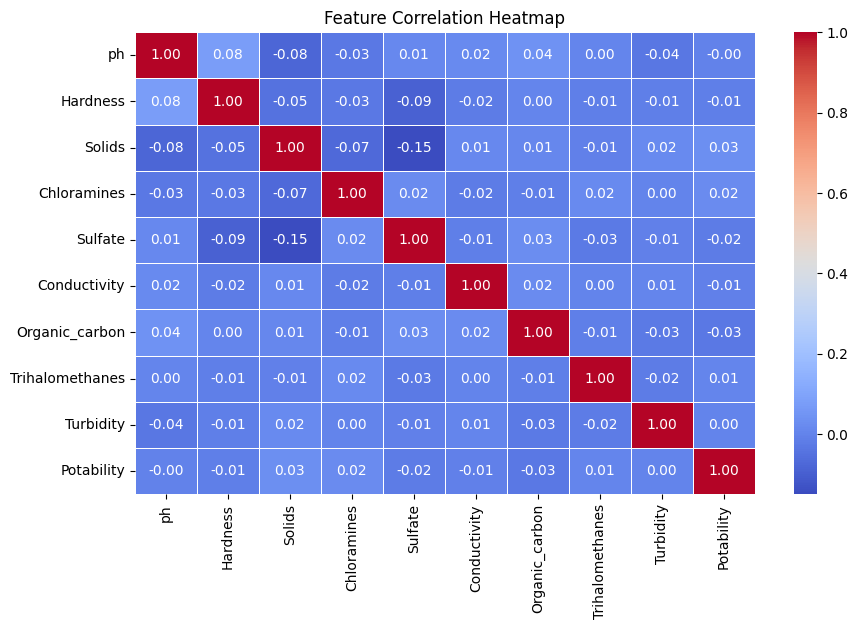

Important Features:
 ph                 1.000000
Solids             0.082004
Hardness           0.075760
Organic_carbon     0.040240
Turbidity          0.036107
Chloramines        0.031741
Conductivity       0.017466
Sulfate            0.014178
Trihalomethanes    0.003145
Potability         0.003014
Name: ph, dtype: float64


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt


# Compute correlation matrix
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Select features with strong correlation (absolute correlation > 0.3)
important_features = correlation_matrix["ph"].abs().sort_values(ascending=False)
print("Important Features:\n", important_features)


**FINAL MODEL**


 Optimized Linear Regression Performance:
  - Train MAE: 1.0569 | Test MAE: 1.0843
  - Train RMSE: 1.4518 | Test RMSE: 1.4832
  - Train R²: 0.0146 | Test R²: 0.0201

 Optimized Random Forest Performance:
  - Train MAE: 0.8582 | Test MAE: 1.0889
  - Train RMSE: 1.1505 | Test RMSE: 1.4719
  - Train R²: 0.3812 | Test R²: 0.0350


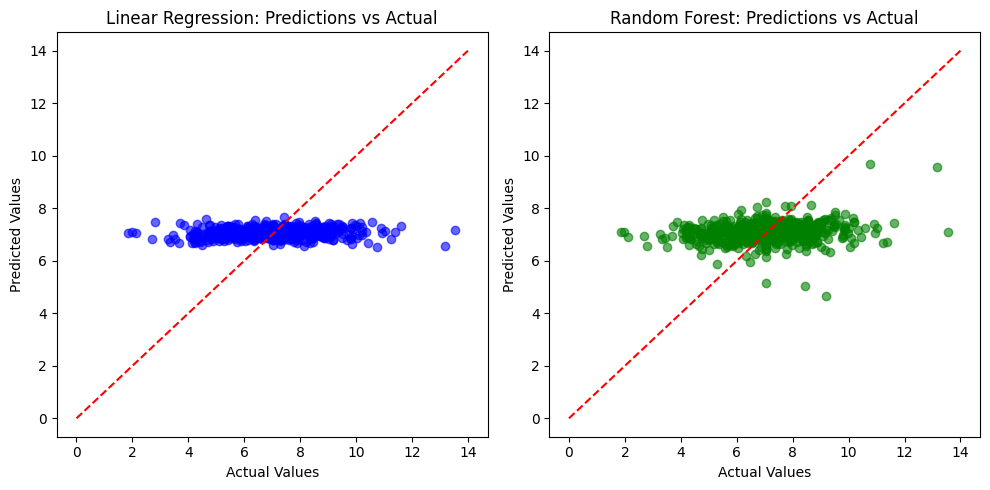

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/final assignment/water_potability.csv')

# Fill missing values before proceeding (using median imputation like before)
df.fillna(df.median(), inplace=True)

selected_features = ['Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity']  # Corrected feature names

X = df[selected_features]
y = df["ph"]

# ... (rest of your code)
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_train_pred_lin = lin_reg.predict(X_train)
y_test_pred_lin = lin_reg.predict(X_test)

# Train Random Forest with best hyperparameters
best_rf_params = {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}
rf_reg = RandomForestRegressor(**best_rf_params, random_state=42)
rf_reg.fit(X_train, y_train)
y_train_pred_rf = rf_reg.predict(X_train)
y_test_pred_rf = rf_reg.predict(X_test)

# Function to evaluate models
def evaluate_model(y_train, y_train_pred, y_test, y_test_pred, model_name):
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"\n {model_name} Performance:")
    print(f"  - Train MAE: {train_mae:.4f} | Test MAE: {test_mae:.4f}")
    print(f"  - Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"  - Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")

# Evaluate both models
evaluate_model(y_train, y_train_pred_lin, y_test, y_test_pred_lin, "Optimized Linear Regression")
evaluate_model(y_train, y_train_pred_rf, y_test, y_test_pred_rf, "Optimized Random Forest")

# Plot predictions vs actual values
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred_lin, color='blue', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression: Predictions vs Actual")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_rf, color='green', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest: Predictions vs Actual")

plt.tight_layout()
plt.show()